Data types in df_rp1:
Stage    object
Jan       int64
Feb       int64
Mar       int64
Apr       int64
May       int64
Jun       int64
Jul       int64
Aug       int64
Sep       int64
Oct       int64
Nov       int64
Dec       int64
Jan.1     int64
Feb.1     int64
Mar.1     int64
Apr.1     int64
May.1     int64
dtype: object

Data types in df_abj:
Stage     object
Apr      float64
May      float64
Jun      float64
Jul      float64
Aug        int64
Sep        int64
Oct        int64
Nov        int64
Dec        int64
Jan        int64
Feb        int64
Mar        int64
Apr.1      int64
May.1      int64
dtype: object

Data types in df_jhb:
Stage     object
Apr      float64
May      float64
Jun      float64
Jul      float64
Aug      float64
Sep      float64
Oct      float64
Nov      float64
Dec        int64
Jan        int64
Feb        int64
Mar        int64
Apr.1      int64
May.1      int64
dtype: object
Index(['Stage', 'Jan 2023', 'Feb 2023', 'Mar 2023', 'Apr 2023', 'May 2023',
       'Jun 2023

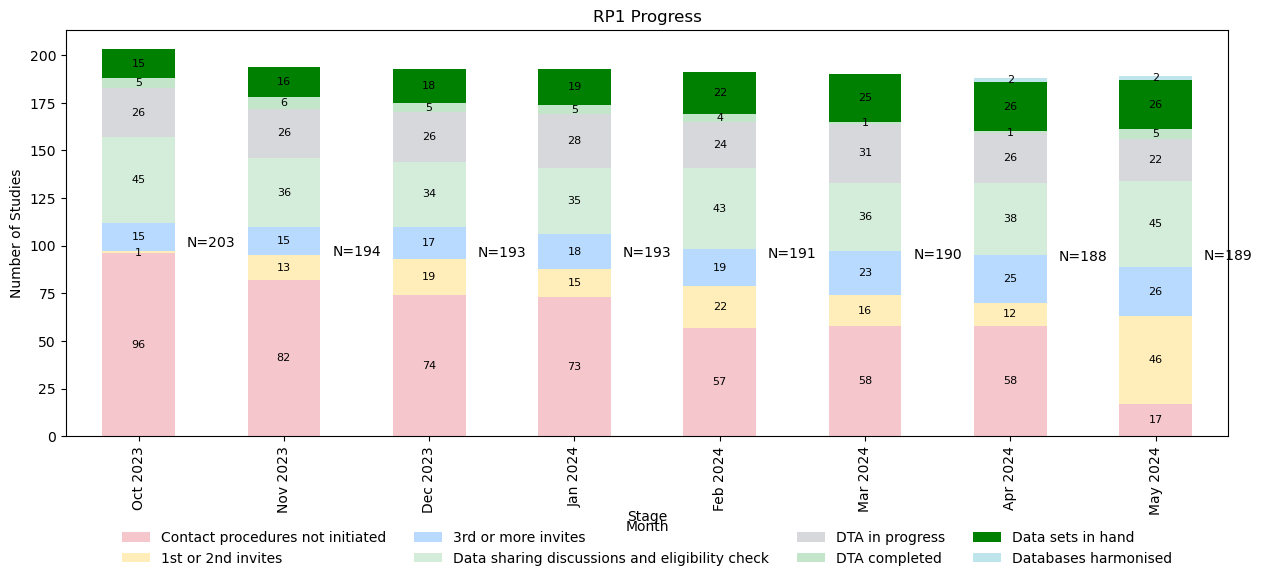

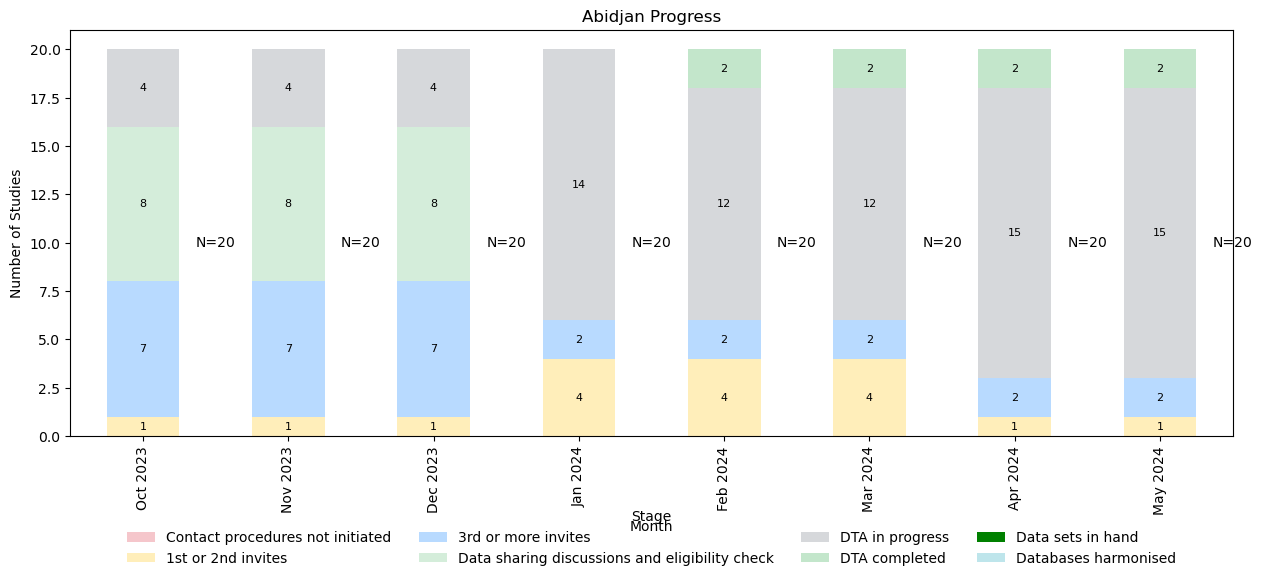

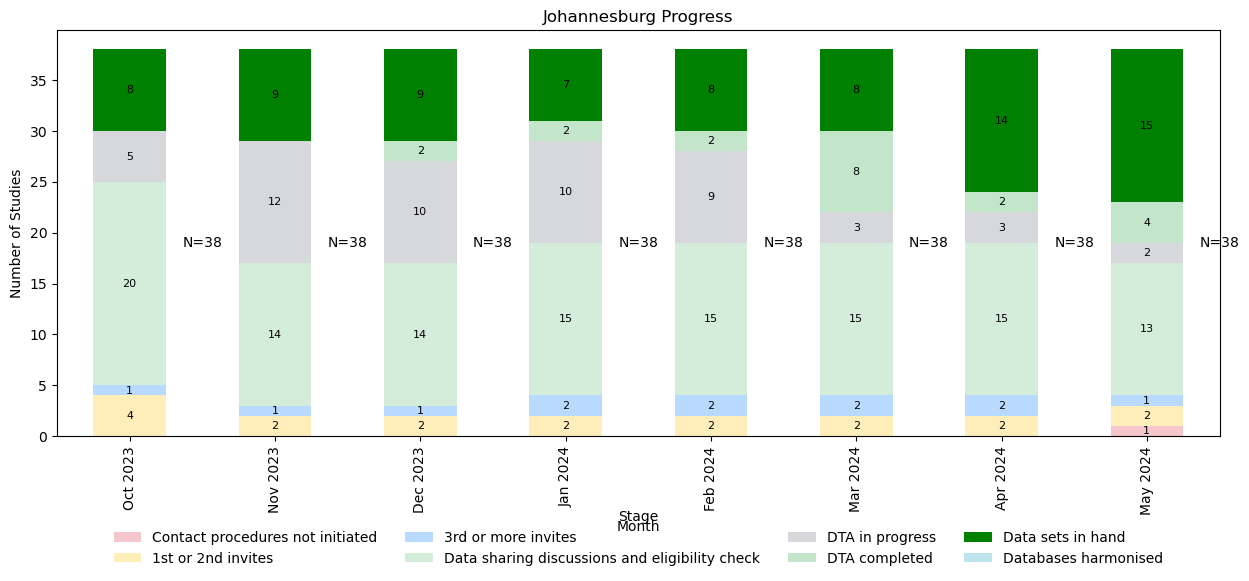

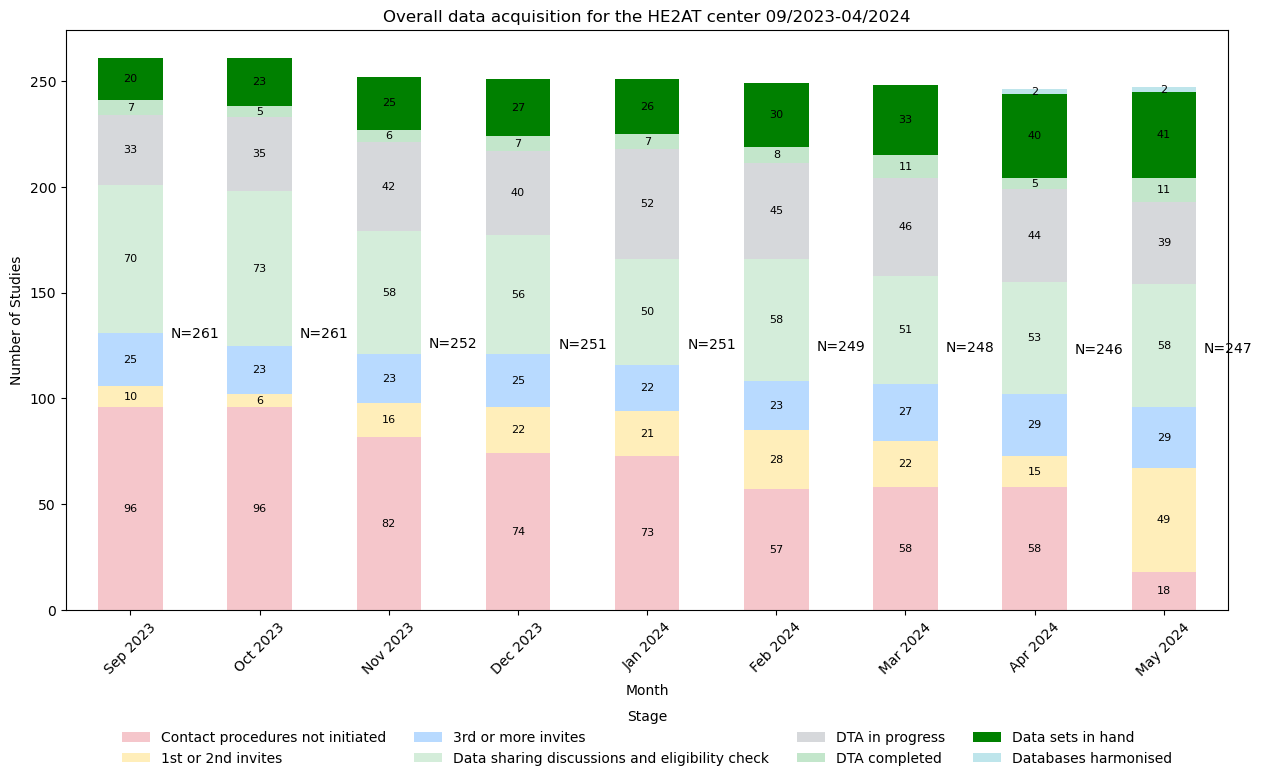

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file
xlsx_file = pd.read_excel('HEAT_Tables_0531.xlsx', sheet_name=['RP1', 'Abj_outputs', 'Jhb_outputs'])

# Extract each DataFrame from the dictionary
df_rp1 = xlsx_file['RP1']
df_abj = xlsx_file['Abj_outputs']
df_jhb = xlsx_file['Jhb_outputs']

# Print the data types of each DataFrame
print("Data types in df_rp1:")
print(df_rp1.dtypes)
print("\nData types in df_abj:")
print(df_abj.dtypes)
print("\nData types in df_jhb:")
print(df_jhb.dtypes)

# Function to map months and years to columns
def map_month_year(df, start_year=2023):
    month_map = {}
    encountered_dec = False  # Flag to indicate if we've encountered 'Dec'
    months_in_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for column in df.columns:
        if any(month in column for month in months_in_order):
            base_month_name = ''.join(filter(str.isalpha, column))
            if base_month_name == 'Jan' and encountered_dec:
                start_year += 1
            if base_month_name == 'Dec':
                encountered_dec = True
            month_map[column] = f'{base_month_name} {start_year}'
    return df.rename(columns=month_map)

# Convert the month columns in each DataFrame to a datetime format
df_rp1 = map_month_year(df_rp1)
df_abj = map_month_year(df_abj)
df_jhb = map_month_year(df_jhb)

# Print the new column names to verify the changes
print(df_rp1.columns)
print(df_abj.columns)
print(df_jhb.columns)

# Convert column names to datetime
def convert_column_to_datetime(df):
    new_columns = []
    for col in df.columns:
        if col == 'Stage':
            new_columns.append(col)
        else:
            date_str = col.strip() + ' 1'
            new_columns.append(pd.to_datetime(date_str, format='%b %Y %d', errors='coerce'))
    df.columns = new_columns

# Apply the conversion to each dataframe
for dataframe in [df_rp1, df_abj, df_jhb]:
    convert_column_to_datetime(dataframe)

# Check for unique and common stages
stages_rp1 = set(df_rp1.index.tolist())
stages_abj = set(df_abj.index.tolist())
stages_jhb = set(df_jhb.index.tolist())

unique_to_rp1 = stages_rp1.difference(stages_abj).difference(stages_jhb)
unique_to_abj = stages_abj.difference(stages_rp1).difference(stages_jhb)
unique_to_jhb = stages_jhb.difference(stages_rp1).difference(stages_abj)
common_stages = stages_rp1.intersection(stages_abj).intersection(stages_jhb)

print("Stages unique to df_rp1:", unique_to_rp1)
print("Stages unique to df_abj:", unique_to_abj)
print("Stages unique to df_jhb:", unique_to_jhb)
print("Common stages:", common_stages)

if unique_to_rp1 or unique_to_abj or unique_to_jhb:
    print("There are differences in the stage names across the dataframes.")
else:
    print("All stage names are consistent across the dataframes.")

# Define the color map and stage order
color_map = {
    'Contact procedures not initiated': '#f5c6cb',
    '1st or 2nd invites': '#ffeeba',
    '3rd or more invites': '#b8daff',
    'Data sharing discussions and eligibility check': '#d4edda',
    'DTA in progress': '#d6d8db',
    'DTA completed': '#c3e6cb',
    'Data sets in hand': 'green',
    'Databases harmonised': '#bee5eb',
    'Ineligible/declined participation/data currently unavailable': '#f5b7b1'
}
stage_order = [
    'Contact procedures not initiated',
    '1st or 2nd invites',
    '3rd or more invites',
    'Data sharing discussions and eligibility check',
    'DTA in progress',
    'DTA completed',
    'Data sets in hand',
    'Databases harmonised',
    'Ineligible/declined participation/data currently unavailable'
]

# Function to plot the main stacked bar chart
def plot_stacked_bar_chart(df, title, last_n_months=8, color_map=None, stage_order=None):
    df = df.set_index('Stage').reindex(stage_order).fillna(0).reset_index()
    excluded_df = df[df['Stage'] == 'Ineligible/declined participation/data currently unavailable']
    df = df[df['Stage'] != 'Ineligible/declined participation/data currently unavailable']
    stages_df = df[~df['Stage'].str.contains("Total")]
    transposed_df = stages_df.set_index('Stage').transpose()
    transposed_df = transposed_df.iloc[-last_n_months:]

    fig, ax = plt.subplots(figsize=(15, 7))
    bars = transposed_df.plot(kind='bar', stacked=True, ax=ax, color=[color_map.get(x, '#333333') for x in stage_order])

    for i, month in enumerate(transposed_df.index):
        month_data = transposed_df.loc[month]
        cumulative_height = month_data.sum()
        total_height = month_data.sum()
        x_position = i + 0.5
        ax.text(x_position, cumulative_height / 2, f"N={int(cumulative_height)}", ha='center', va='center')

        for j, (stage, value) in enumerate(month_data.items()):
            if value > 0:
                height = sum(month_data[:j+1]) - (value / 2)
                ax.text(i, height, f'{int(value)}', ha='center', va='center', fontsize=8)

    ax.set_xticklabels([x.strftime('%b %Y') for x in transposed_df.index])
    ax.legend(title='Stage', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(stage_order)//2, frameon=False)
    plt.subplots_adjust(bottom=0.3)
    ax.set_title(title)
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Studies')
    
    return ax

# Function to overlay excluded studies
def overlay_excluded_studies(ax, excluded_df, transposed_df):
    if not excluded_df.empty:
        excluded_df = excluded_df.drop(columns=['Stage'], errors='ignore')
        excluded_totals = excluded_df.transpose().sum()
        if not excluded_totals.empty:
            for i, month in enumerate(transposed_df.index):
                if month in excluded_totals.index:
                    excluded = excluded_totals[month]
                    if excluded > 0:
                        ax.text(i, transposed_df.loc[month].sum() / 2, f"n={int(excluded)}", ha='center', va='bottom', color='red', fontsize=10, fontweight='bold')

# Plot for each DataFrame
ax_rp1 = plot_stacked_bar_chart(df_rp1, 'RP1 Progress', last_n_months=8, color_map=color_map, stage_order=stage_order)
overlay_excluded_studies(ax_rp1, df_rp1[df_rp1['Stage'] == 'Ineligible/declined participation/data currently unavailable'], df_rp1.set_index('Stage').transpose().iloc[-8:])

ax_abj = plot_stacked_bar_chart(df_abj, 'Abidjan Progress', last_n_months=8, color_map=color_map, stage_order=stage_order)
overlay_excluded_studies(ax_abj, df_abj[df_abj['Stage'] == 'Ineligible/declined participation/data currently unavailable'], df_abj.set_index('Stage').transpose().iloc[-8:])

ax_jhb = plot_stacked_bar_chart(df_jhb, 'Johannesburg Progress', last_n_months=8, color_map=color_map, stage_order=stage_order)
overlay_excluded_studies(ax_jhb, df_jhb[df_jhb['Stage'] == 'Ineligible/declined participation/data currently unavailable'], df_jhb.set_index('Stage').transpose().iloc[-8:])

# Combining and plotting function for multiple dataframes
def combine_and_plot_stacked_bars(dfs, title, start_month=9, start_year=2023, stage_order=None, color_map=None):
    combined_df = pd.DataFrame()
    excluded_df = pd.DataFrame()
    for df in dfs:
        df = df.fillna(0).set_index('Stage').reindex(stage_order).fillna(0)
        if 'Ineligible/declined participation/data currently unavailable' in df.index:
            excluded_df = excluded_df.add(df.loc[['Ineligible/declined participation/data currently unavailable']], fill_value=0)
            df = df.drop(['Ineligible/declined participation/data currently unavailable'])
        combined_df = combined_df.add(df, fill_value=0) if not combined_df.empty else df
    transposed_combined_df = combined_df.transpose()
    transposed_combined_df.index = pd.to_datetime(transposed_combined_df.index)
    start_date = pd.Timestamp(year=start_year, month=start_month, day=1)
    filtered_df = transposed_combined_df[transposed_combined_df.index >= start_date]

    fig, ax = plt.subplots(figsize=(15, 10))
    bars = filtered_df.plot(kind='bar', stacked=True, ax=ax, color=[color_map.get(stage) for stage in stage_order])

    for i, month in enumerate(filtered_df.index):
        month_data = filtered_df.loc[month]
        cumulative_height = month_data.sum()
        total_height = month_data.sum()
        x_position = i + 0.5
        ax.text(x_position, cumulative_height / 2, f"N={int(cumulative_height)}", ha='center', va='center')

        for j, (stage, value) in enumerate(month_data.items()):
            if value > 0:
                height = sum(month_data[:j+1]) - (value / 2)
                ax.text(i, height, f'{int(value)}', ha='center', va='center', fontsize=8)

    ax.set_xticklabels([index.strftime('%b %Y') for index in filtered_df.index], rotation=45)
    ax.legend(title='Stage', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(stage_order)//2, frameon=False)
    plt.subplots_adjust(bottom=0.3)
    ax.set_title(title)
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Studies')
    
    overlay_excluded_studies(ax, excluded_df, filtered_df)
    plt.show()

combine_and_plot_stacked_bars(
    [df_rp1, df_abj, df_jhb],
    'Overall data acquisition for the HE2AT center 09/2023-04/2024',
    start_month=9,
    start_year=2023,
    stage_order=stage_order,
    color_map=color_map
)


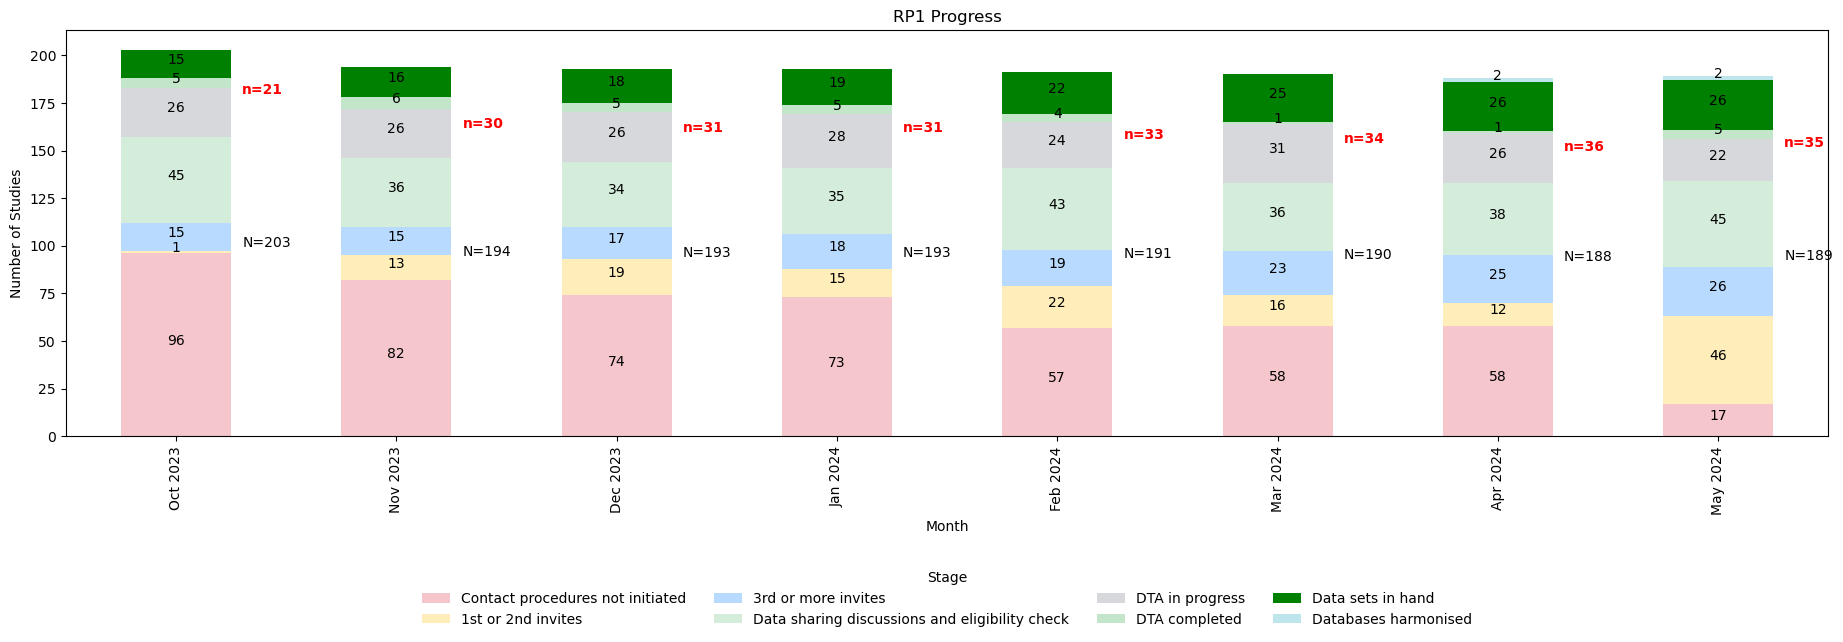

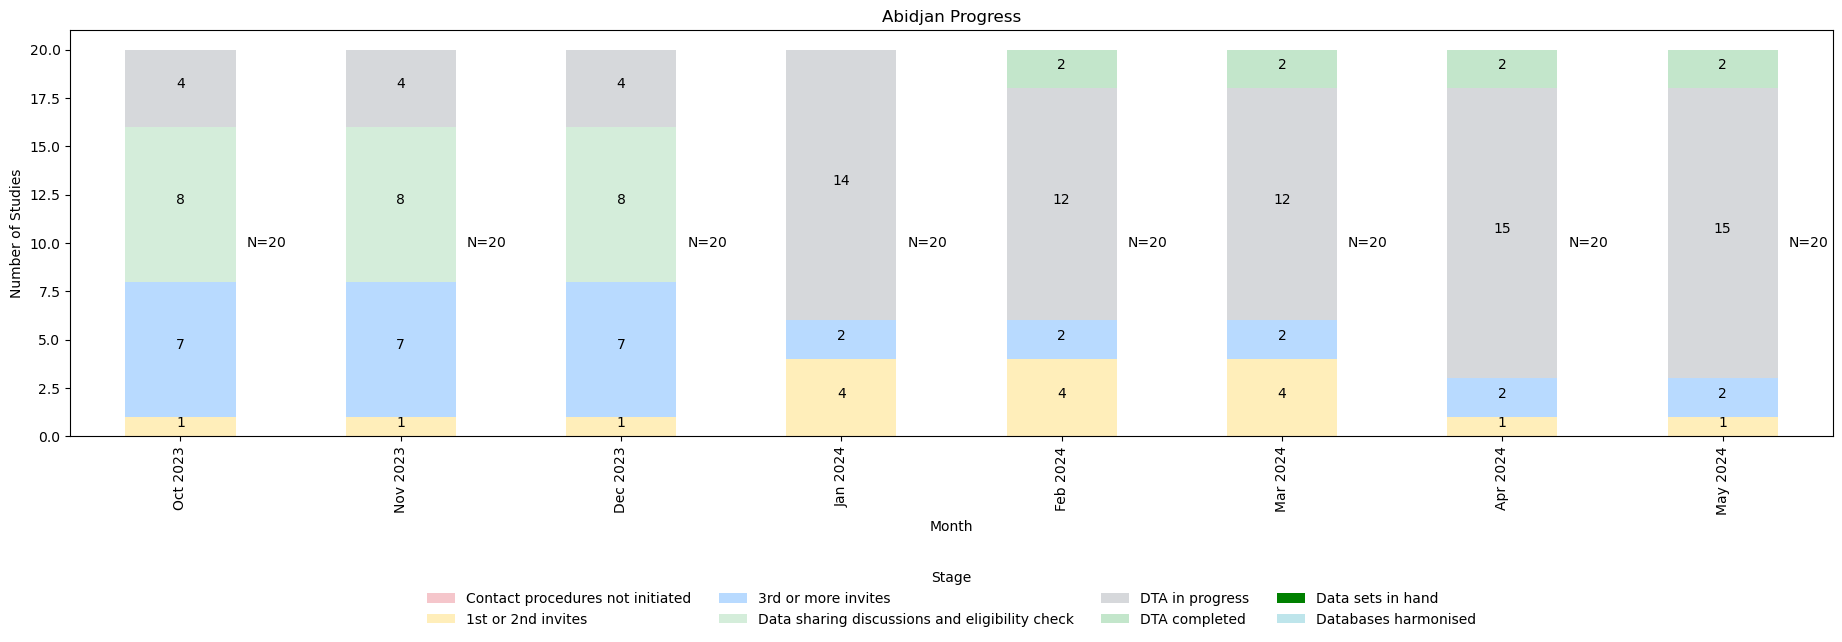

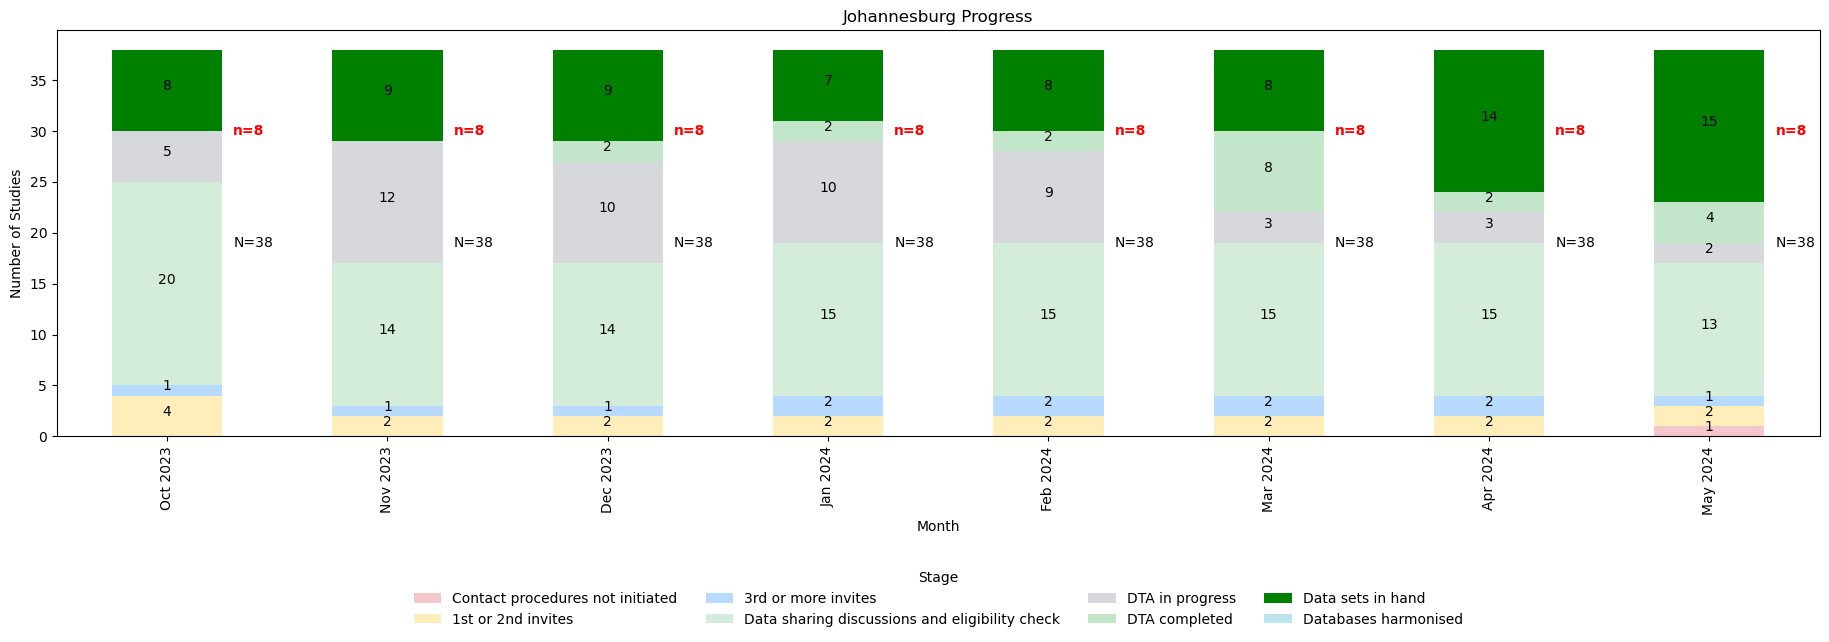

In [2]:
def plot_stacked_bar_chart(df, title, last_n_months=8, color_map=None, stage_order=None):
    df = df.set_index('Stage').reindex(stage_order).reset_index()
    stages_df = df[~df['Stage'].str.contains("Total")]
    transposed_df = stages_df.set_index('Stage').transpose()
    transposed_df = transposed_df.iloc[-last_n_months:]

    # Exclude 'Ineligible/declined participation/data currently unavailable' from the plot
    plot_df = transposed_df.drop(columns=['Ineligible/declined participation/data currently unavailable'], errors='ignore')

    fig, ax = plt.subplots(figsize=(15, 7))
    bars = plot_df.plot(kind='bar', stacked=True, ax=ax, color=[color_map.get(x, '#333333') for x in stage_order if x in plot_df.columns])

    for bar in bars.containers:
        labels = [f'{v.get_height():.0f}' if v.get_height() != 0 else '' for v in bar]
        ax.bar_label(bar, labels=labels, label_type='center', padding=3)

    for i, month in enumerate(transposed_df.index):
        month_data = transposed_df.loc[month]
        cumulative_height = float(month_data.drop('Ineligible/declined participation/data currently unavailable', errors='ignore').sum())
        excluded_height = float(month_data.get('Ineligible/declined participation/data currently unavailable', 0))

        x_position = i + 0.5
        # Adjust the positions of the N= and n= labels
        ax.text(i + 0.3, cumulative_height / 2, f"N={cumulative_height:.0f}", ha='left', va='center')
        if excluded_height > 0:
            ax.text(i + 0.3, cumulative_height - (excluded_height), f"n={excluded_height:.0f}", ha='left', va='center', color='red', fontsize=10, fontweight='bold')

    ax.set_xticklabels([x.strftime('%b %Y') for x in transposed_df.index])
    ax.legend(title='Stage', loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=len(stage_order)//2, frameon=False)
    plt.subplots_adjust(bottom=0.3, right=1.3)
    ax.set_title(title)
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Studies')
    plt.show()

# Plot for each DataFrame
plot_stacked_bar_chart(df_rp1, 'RP1 Progress', last_n_months=8, color_map=color_map, stage_order=stage_order)
plot_stacked_bar_chart(df_abj, 'Abidjan Progress', last_n_months=8, color_map=color_map, stage_order=stage_order)
plot_stacked_bar_chart(df_jhb, 'Johannesburg Progress', last_n_months=8, color_map=color_map, stage_order=stage_order)

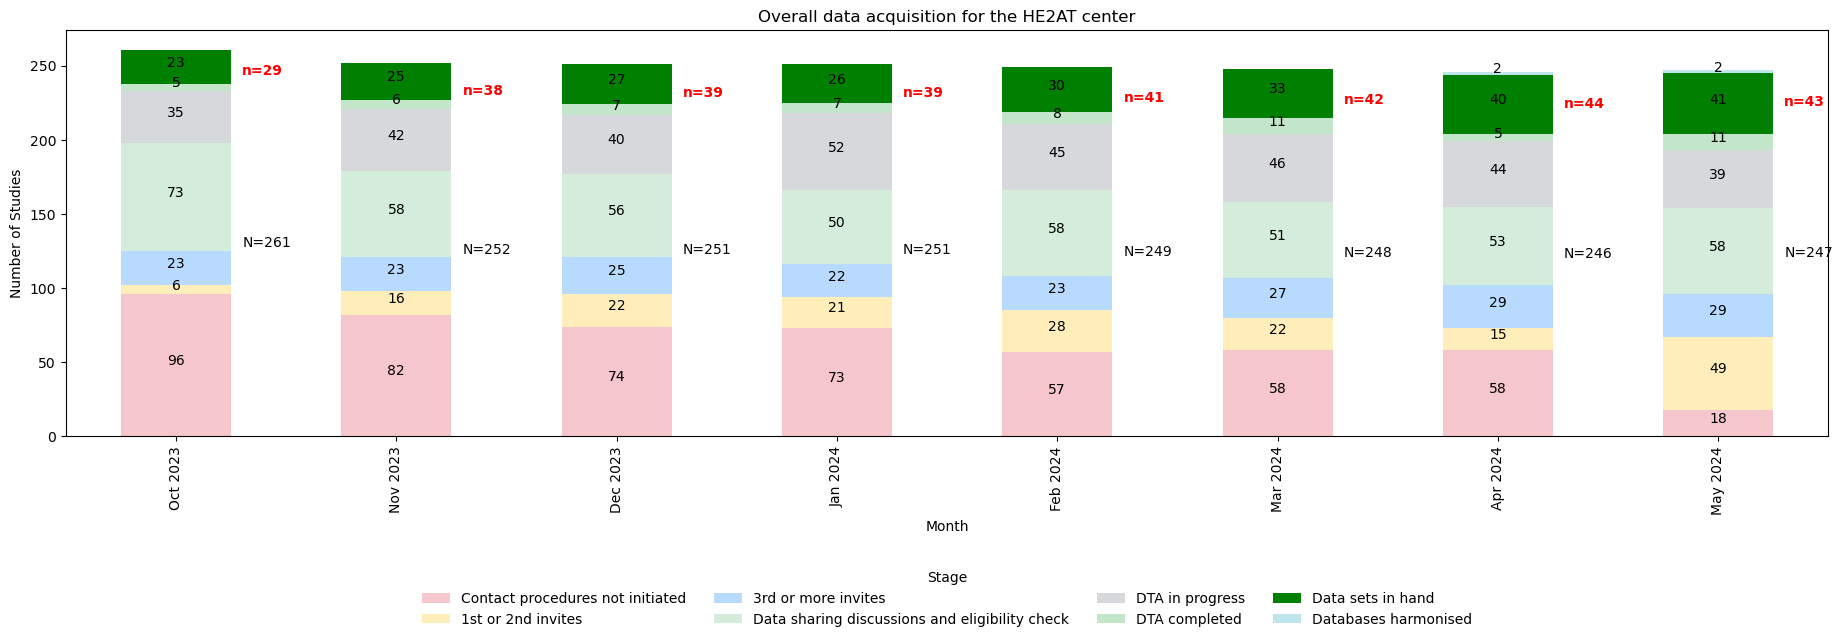

In [3]:
# Function to combine and plot the cumulative stacked bar chart
def plot_cumulative_stacked_bar_chart(dfs, title, last_n_months=8, color_map=None, stage_order=None):
    combined_df = pd.DataFrame()
    for df in dfs:
        df = df.set_index('Stage').reindex(stage_order).reset_index()
        stages_df = df[~df['Stage'].str.contains("Total")]
        if combined_df.empty:
            combined_df = stages_df
        else:
            combined_df = combined_df.set_index('Stage').add(stages_df.set_index('Stage'), fill_value=0).reset_index()
    transposed_df = combined_df.set_index('Stage').transpose()
    transposed_df = transposed_df.iloc[-last_n_months:]

    # Exclude 'Ineligible/declined participation/data currently unavailable' from the plot
    plot_df = transposed_df.drop(columns=['Ineligible/declined participation/data currently unavailable'], errors='ignore')

    fig, ax = plt.subplots(figsize=(15, 7))
    bars = plot_df.plot(kind='bar', stacked=True, ax=ax, color=[color_map.get(x, '#333333') for x in stage_order if x in plot_df.columns])

    for bar in bars.containers:
        labels = [f'{v.get_height():.0f}' if v.get_height() != 0 else '' for v in bar]
        ax.bar_label(bar, labels=labels, label_type='center', padding=3)

    for i, month in enumerate(transposed_df.index):
        month_data = transposed_df.loc[month]
        cumulative_height = float(month_data.drop('Ineligible/declined participation/data currently unavailable', errors='ignore').sum())
        excluded_height = float(month_data.get('Ineligible/declined participation/data currently unavailable', 0))

        x_position = i + 0.5
        # Adjust the positions of the N= and n= labels
        ax.text(i + 0.3, cumulative_height / 2, f"N={cumulative_height:.0f}", ha='left', va='center')
        if excluded_height > 0:
            ax.text(i + 0.3, cumulative_height - (excluded_height / 2), f"n={excluded_height:.0f}", ha='left', va='center', color='red', fontsize=10, fontweight='bold')

    ax.set_xticklabels([x.strftime('%b %Y') for x in transposed_df.index])
    ax.legend(title='Stage', loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=len(stage_order)//2, frameon=False)
    plt.subplots_adjust(bottom=0.3, right=1.3)
    ax.set_title(title)
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Studies')
    plt.show()

# Plot the cumulative graph
plot_cumulative_stacked_bar_chart(
    [df_rp1, df_abj, df_jhb],
    'Overall data acquisition for the HE2AT center',
    last_n_months=8,
    color_map=color_map,
    stage_order=stage_order
)

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file
xlsx_file = pd.read_excel('HEAT_Tables_0531.xlsx', sheet_name=['RP1', 'Abj_outputs', 'Jhb_outputs'])

# Extract each DataFrame from the dictionary
df_rp1 = xlsx_file['RP1']
df_abj = xlsx_file['Abj_outputs']
df_jhb = xlsx_file['Jhb_outputs']

# Function to map month-year columns
def map_month_year(df):
    month_map = {}
    months_in_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for col in df.columns:
        if any(month in col for month in months_in_order):
            year_suffix = ''.join(filter(str.isdigit, col)) if any(char.isdigit() for char in col) else '2023'
            month_name = ''.join(filter(str.isalpha, col))
            new_col_name = f'{month_name} {year_suffix}'
            month_map[col] = new_col_name
    return df.rename(columns=month_map)

# Apply month-year mapping
df_rp1 = map_month_year(df_rp1)
df_abj = map_month_year(df_abj)
df_jhb = map_month_year(df_jhb)

# Print the new column names to verify the changes
print(df_rp1.columns)
print(df_abj.columns)
print(df_jhb.columns)

# Function to convert column names to datetime
def convert_columns_to_datetime(df):
    new_columns = []
    for col in df.columns:
        if col == 'Stage':
            new_columns.append(col)
        else:
            date_str = col + ' 1'
            new_columns.append(pd.to_datetime(date_str, format='%b %Y %d', errors='coerce'))
    df.columns = new_columns

# Apply conversion to datetime columns
for dataframe in [df_rp1, df_abj, df_jhb]:
    convert_columns_to_datetime(dataframe)



Index(['Stage', 'Jan 2023', 'Feb 2023', 'Mar 2023', 'Apr 2023', 'May 2023',
       'Jun 2023', 'Jul 2023', 'Aug 2023', 'Sep 2023', 'Oct 2023', 'Nov 2023',
       'Dec 2023', 'Jan 1', 'Feb 1', 'Mar 1', 'Apr 1', 'May 1'],
      dtype='object')
Index(['Stage', 'Apr 2023', 'May 2023', 'Jun 2023', 'Jul 2023', 'Aug 2023',
       'Sep 2023', 'Oct 2023', 'Nov 2023', 'Dec 2023', 'Jan 2023', 'Feb 2023',
       'Mar 2023', 'Apr 1', 'May 1'],
      dtype='object')
Index(['Stage', 'Apr 2023', 'May 2023', 'Jun 2023', 'Jul 2023', 'Aug 2023',
       'Sep 2023', 'Oct 2023', 'Nov 2023', 'Dec 2023', 'Jan 2023', 'Feb 2023',
       'Mar 2023', 'Apr 1', 'May 1'],
      dtype='object')


In [5]:
import pandas as pd



# Create a DataFrame from the data
df_rp1_countries = pd.read_excel('HEAT_Tables_0531.xlsx', sheet_name='RP1_Countries')

# Calculate the total number of studies for each country
df_rp1_countries['Total Studies'] = df_rp1_countries.drop('Study site', axis=1).sum(axis=1)

# Create a formatted output for each country
df_rp1_countries['Formatted'] = df_rp1_countries['Study site'] + " (n=" + df_rp1_countries['Total Studies'].astype(str) + ")"
formatted_output = df_rp1_countries[['Study site', 'Formatted']].set_index('Study site')

# Print the formatted summary
print(formatted_output)


                            Formatted
Study site                           
Benin                   Benin (n=3.0)
Burkina Faso     Burkina Faso (n=4.0)
Cameroon             Cameroon (n=2.0)
Côte d'Ivoire   Côte d'Ivoire (n=1.0)
Ethiopia            Ethiopia (n=18.0)
Gambia                 Gambia (n=1.0)
Ghana                  Ghana (n=10.0)
Kenya                  Kenya (n=17.0)
Malawi                Malawi (n=19.0)
Multi-country  Multi-country (n=25.0)
Nigeria               Nigeria (n=8.0)
Senegal               Senegal (n=1.0)
South Africa    South Africa (n=32.0)
Tanzania            Tanzania (n=23.0)
Uganda                Uganda (n=17.0)
Zimbabwe             Zimbabwe (n=2.0)


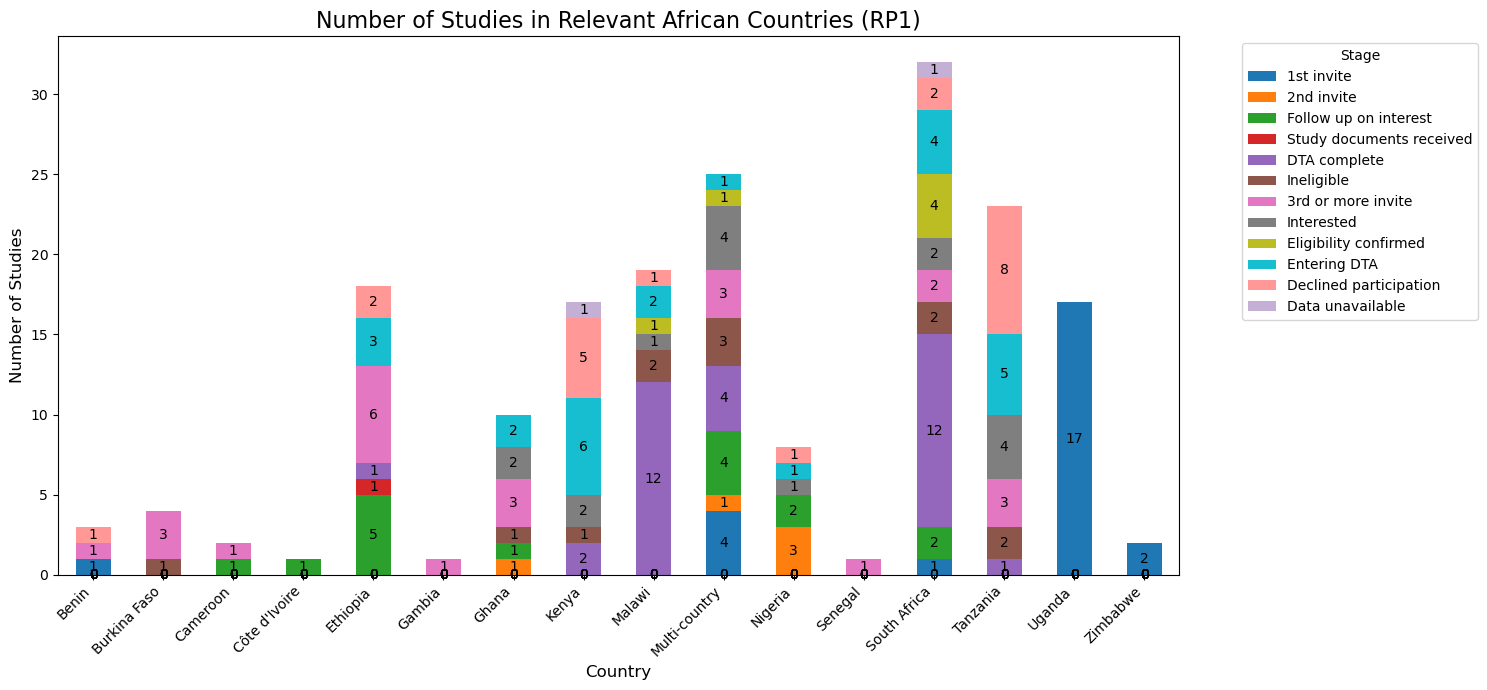

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the Excel file
file_path = 'HEAT_Tables_0531.xlsx'
df_rp1_countries = pd.read_excel(file_path, sheet_name='RP1_Countries')

# Create a list of stages in the correct order
stage_order = ['1st invite', '2nd invite', 'Follow up on interest', 'Study documents received', 
               'DTA complete', 'Ineligible', '3rd or more invite', 'Interested', 'Eligibility confirmed', 
               'Entering DTA', 'Declined participation', 'Data unavailable']

# Set the 'Study site' column as the index
df_rp1_countries.set_index('Study site', inplace=True)

# Plot the stacked bar chart
ax = df_rp1_countries[stage_order].plot(kind='bar', stacked=True, figsize=(15, 7), color=[
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 
    '#bcbd22', '#17becf', '#ff9896', '#c5b0d5'
])

# Add the data labels
for container in ax.containers:
    ax.bar_label(container, label_type='center')

# Set the title and labels
plt.title('Number of Studies in Relevant African Countries (RP1)', fontsize=16)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Number of Studies', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Stage', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()


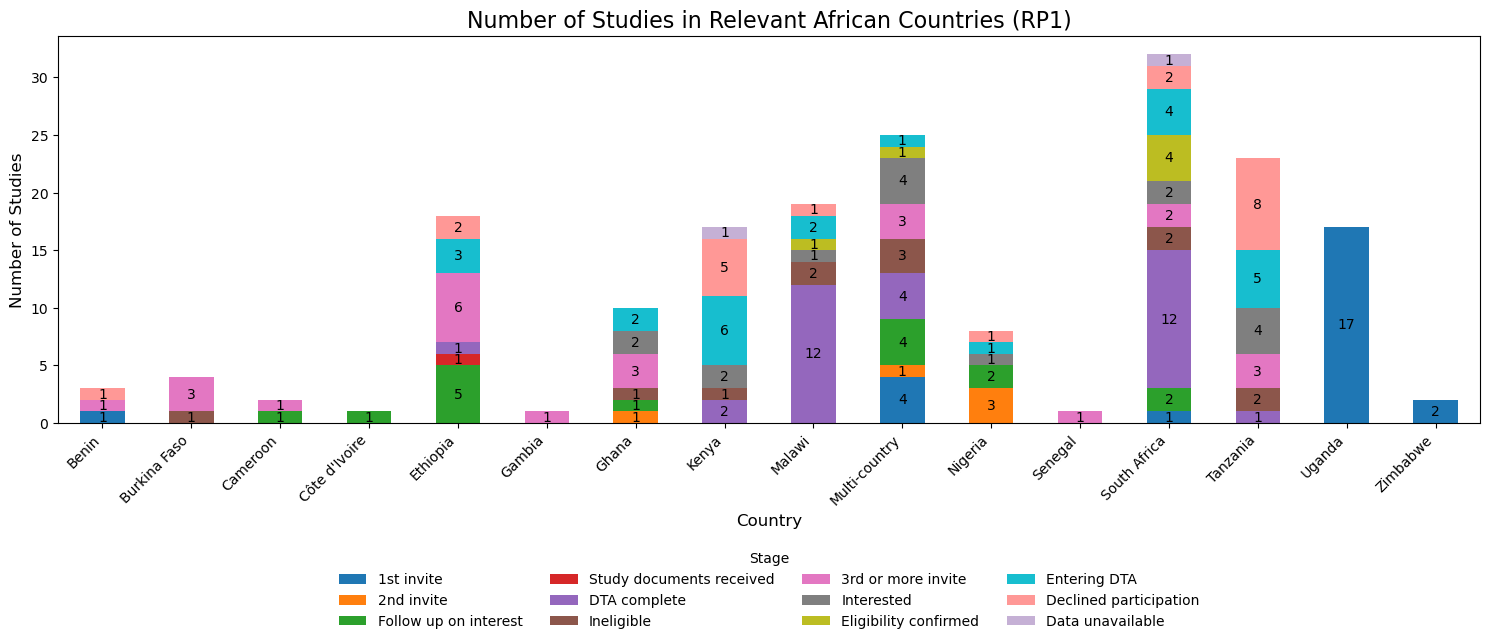

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the Excel file
file_path = 'HEAT_Tables_0531.xlsx'
df_rp1_countries = pd.read_excel(file_path, sheet_name='RP1_Countries')

# Define the color map and stage order
color_map = {
    '1st invite': '#1f77b4',
    '2nd invite': '#ff7f0e',
    'Follow up on interest': '#2ca02c',
    'Study documents received': '#d62728',
    'DTA complete': '#9467bd',
    'Ineligible': '#8c564b',
    '3rd or more invite': '#e377c2',
    'Interested': '#7f7f7f',
    'Eligibility confirmed': '#bcbd22',
    'Entering DTA': '#17becf',
    'Declined participation': '#ff9896',
    'Data unavailable': '#c5b0d5'
}
stage_order = [
    '1st invite', '2nd invite', 'Follow up on interest', 'Study documents received', 
    'DTA complete', 'Ineligible', '3rd or more invite', 'Interested', 'Eligibility confirmed', 
    'Entering DTA', 'Declined participation', 'Data unavailable'
]

# Set the 'Study site' column as the index
df_rp1_countries.set_index('Study site', inplace=True)

# Plot the stacked bar chart
fig, ax = plt.subplots(figsize=(15, 7))
df_rp1_countries[stage_order].plot(kind='bar', stacked=True, ax=ax, color=[color_map[stage] for stage in stage_order])

# Add the data labels
for container in ax.containers:
    labels = [f'{int(v.get_height())}' if v.get_height() > 0 else '' for v in container]
    ax.bar_label(container, labels=labels, label_type='center')

# Set the title and labels
plt.title('Number of Studies in Relevant African Countries (RP1)', fontsize=16)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Number of Studies', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Place the legend below the plot
ax.legend(title='Stage', bbox_to_anchor=(0.5, -0.3), loc='upper center', ncol=4, frameon=False)
plt.tight_layout()

plt.show()


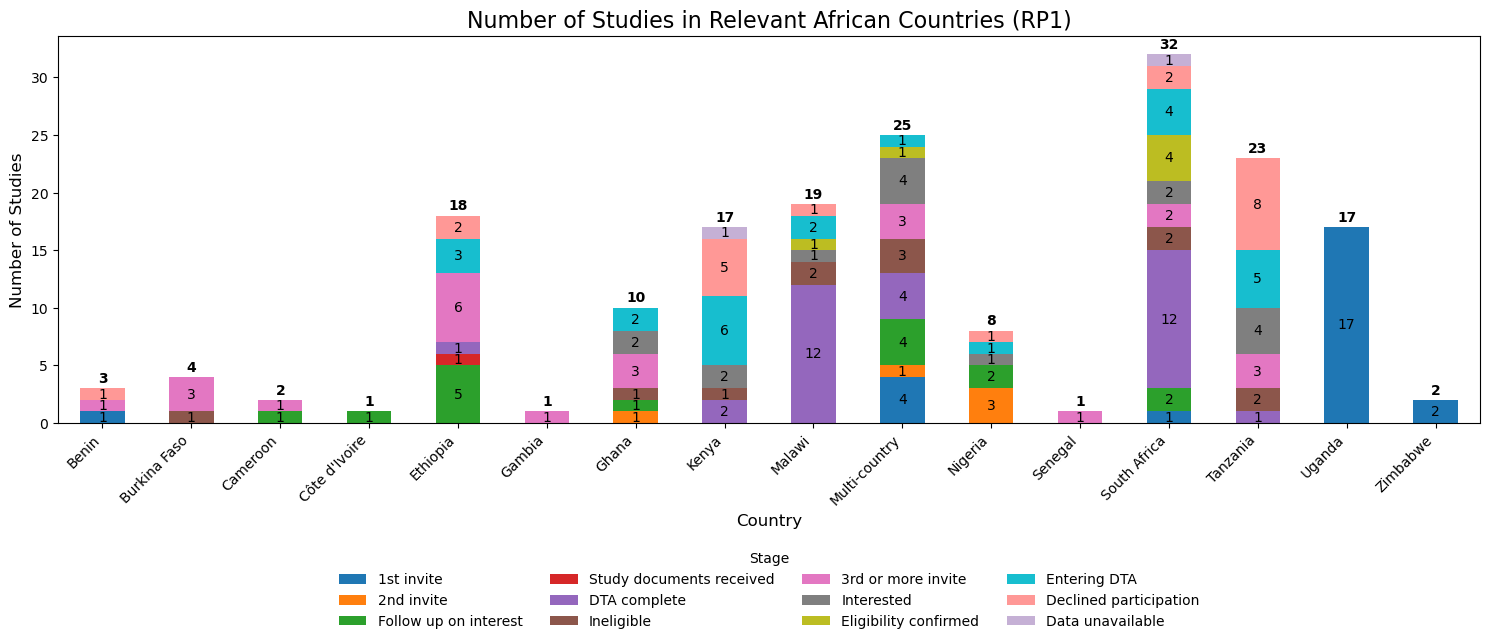

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the Excel file
file_path = 'HEAT_Tables_0531.xlsx'
df_rp1_countries = pd.read_excel(file_path, sheet_name='RP1_Countries')

# Define the color map and stage order
color_map = {
    '1st invite': '#1f77b4',
    '2nd invite': '#ff7f0e',
    'Follow up on interest': '#2ca02c',
    'Study documents received': '#d62728',
    'DTA complete': '#9467bd',
    'Ineligible': '#8c564b',
    '3rd or more invite': '#e377c2',
    'Interested': '#7f7f7f',
    'Eligibility confirmed': '#bcbd22',
    'Entering DTA': '#17becf',
    'Declined participation': '#ff9896',
    'Data unavailable': '#c5b0d5'
}
stage_order = [
    '1st invite', '2nd invite', 'Follow up on interest', 'Study documents received', 
    'DTA complete', 'Ineligible', '3rd or more invite', 'Interested', 'Eligibility confirmed', 
    'Entering DTA', 'Declined participation', 'Data unavailable'
]

# Set the 'Study site' column as the index
df_rp1_countries.set_index('Study site', inplace=True)

# Plot the stacked bar chart
fig, ax = plt.subplots(figsize=(15, 7))
df_rp1_countries[stage_order].plot(kind='bar', stacked=True, ax=ax, color=[color_map[stage] for stage in stage_order])

# Add the data labels
for container in ax.containers:
    labels = [f'{int(v.get_height())}' if v.get_height() > 0 else '' for v in container]
    ax.bar_label(container, labels=labels, label_type='center')

# Add the total labels on top of each stack
totals = df_rp1_countries[stage_order].sum(axis=1)
for i, total in enumerate(totals):
    ax.text(i, total + 0.5, f'{int(total)}', ha='center', fontsize=10, fontweight='bold')

# Set the title and labels
plt.title('Number of Studies in Relevant African Countries (RP1)', fontsize=16)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Number of Studies', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Place the legend below the plot
ax.legend(title='Stage', bbox_to_anchor=(0.5, -0.3), loc='upper center', ncol=4, frameon=False)
plt.tight_layout()

plt.show()


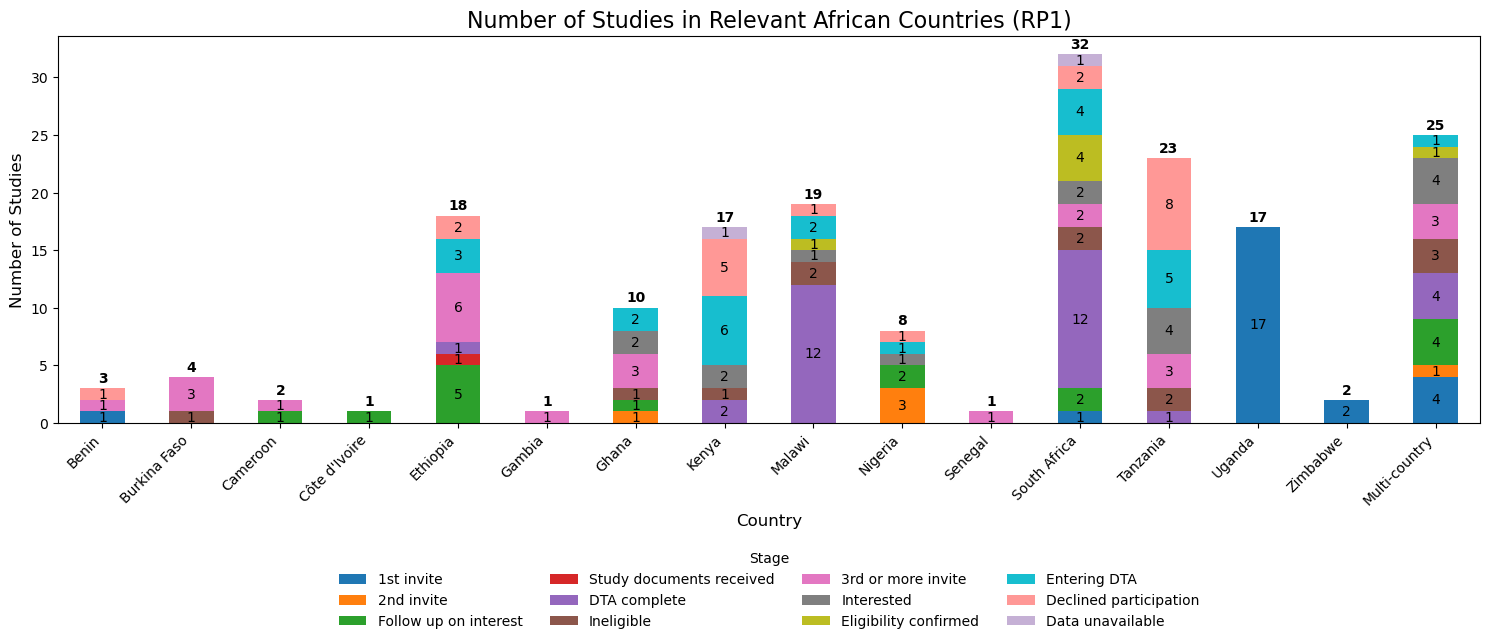

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the Excel file
file_path = 'HEAT_Tables_0531.xlsx'
df_rp1_countries = pd.read_excel(file_path, sheet_name='RP1_Countries')

# Define the color map and stage order
color_map = {
    '1st invite': '#1f77b4',
    '2nd invite': '#ff7f0e',
    'Follow up on interest': '#2ca02c',
    'Study documents received': '#d62728',
    'DTA complete': '#9467bd',
    'Ineligible': '#8c564b',
    '3rd or more invite': '#e377c2',
    'Interested': '#7f7f7f',
    'Eligibility confirmed': '#bcbd22',
    'Entering DTA': '#17becf',
    'Declined participation': '#ff9896',
    'Data unavailable': '#c5b0d5'
}
stage_order = [
    '1st invite', '2nd invite', 'Follow up on interest', 'Study documents received', 
    'DTA complete', 'Ineligible', '3rd or more invite', 'Interested', 'Eligibility confirmed', 
    'Entering DTA', 'Declined participation', 'Data unavailable'
]

# Set the 'Study site' column as the index
df_rp1_countries.set_index('Study site', inplace=True)

# Move the 'Multi-country' column to the end
multi_country_row = df_rp1_countries.loc['Multi-country']
df_rp1_countries = df_rp1_countries.drop('Multi-country')
df_rp1_countries.loc['Multi-country'] = multi_country_row

# Plot the stacked bar chart
fig, ax = plt.subplots(figsize=(15, 7))
df_rp1_countries[stage_order].plot(kind='bar', stacked=True, ax=ax, color=[color_map[stage] for stage in stage_order])

# Add the data labels
for container in ax.containers:
    labels = [f'{int(v.get_height())}' if v.get_height() > 0 else '' for v in container]
    ax.bar_label(container, labels=labels, label_type='center')

# Add the total labels on top of each stack
totals = df_rp1_countries[stage_order].sum(axis=1)
for i, total in enumerate(totals):
    ax.text(i, total + 0.5, f'{int(total)}', ha='center', fontsize=10, fontweight='bold')

# Set the title and labels
plt.title('Number of Studies in Relevant African Countries (RP1)', fontsize=16)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Number of Studies', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Place the legend below the plot
ax.legend(title='Stage', bbox_to_anchor=(0.5, -0.3), loc='upper center', ncol=4, frameon=False)
plt.tight_layout()

plt.show()


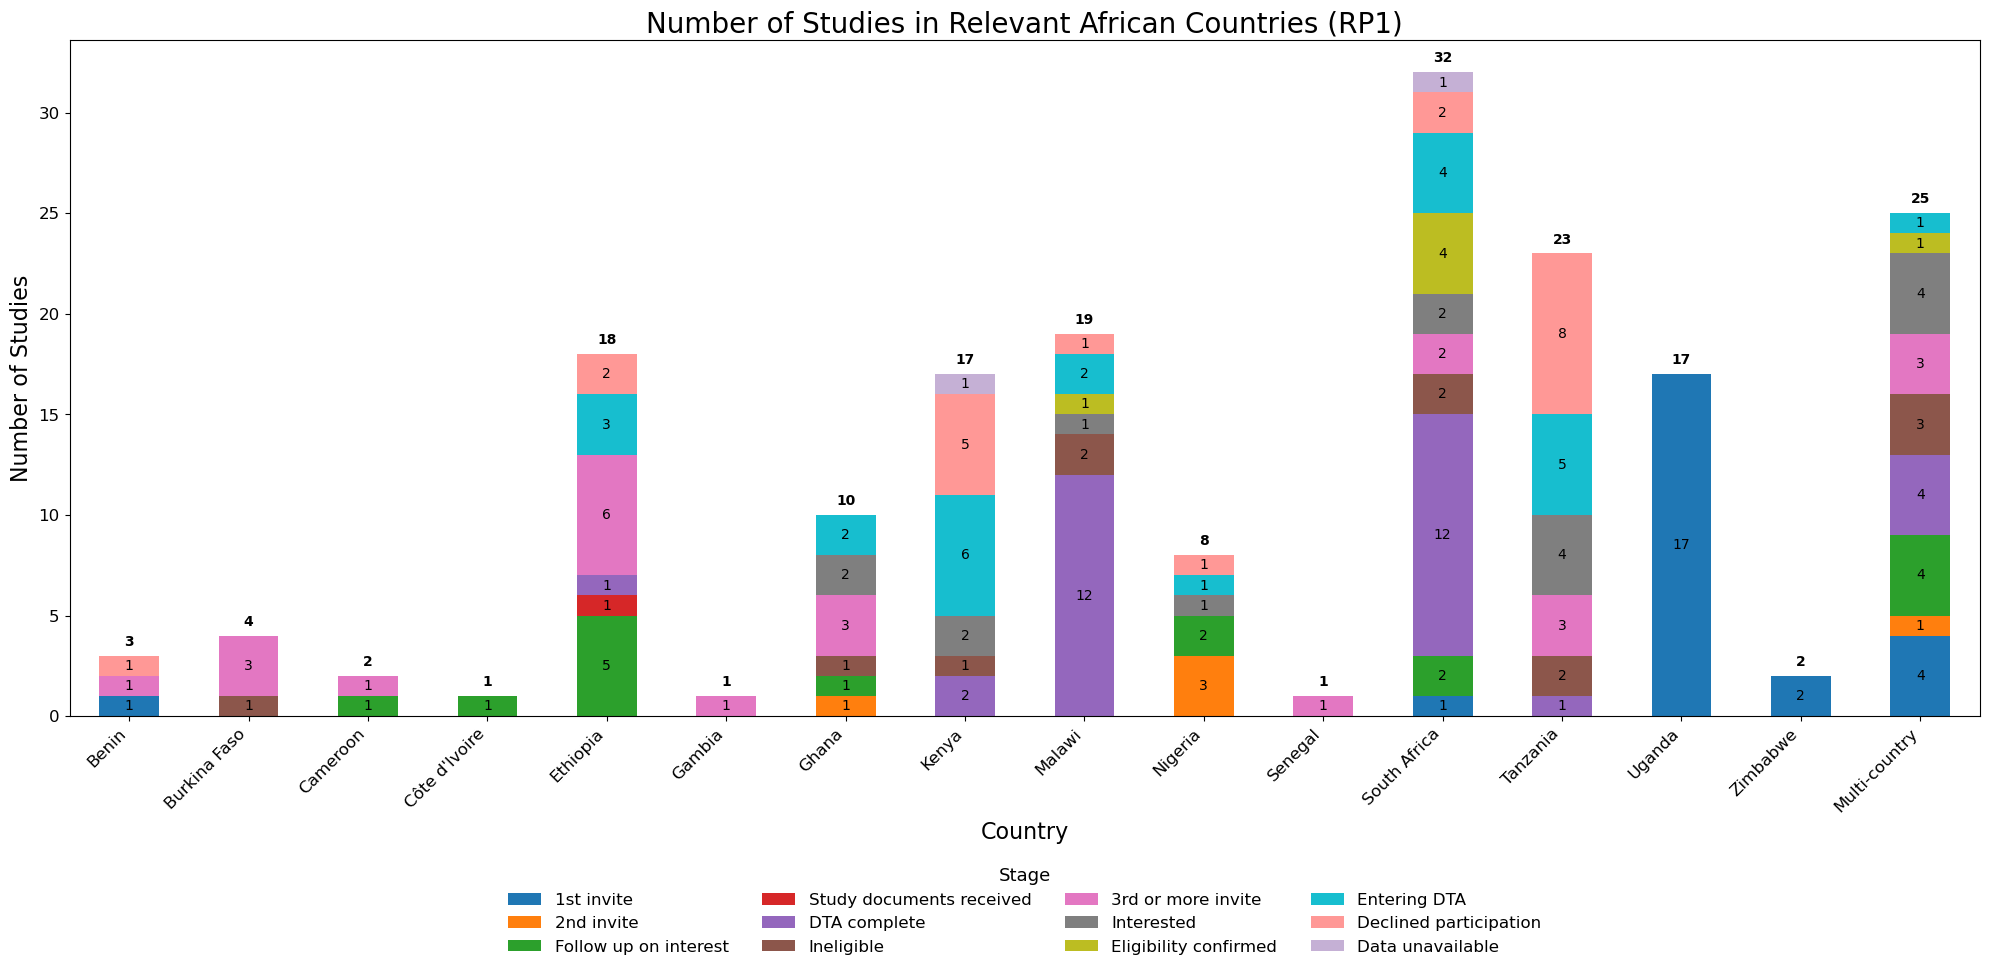

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the Excel file
#file_path = '/mnt/data/HEAT_Tables_0531.xlsx'
df_rp1_countries = pd.read_excel(file_path, sheet_name='RP1_Countries')

# Define the color map and stage order
color_map = {
    '1st invite': '#1f77b4',
    '2nd invite': '#ff7f0e',
    'Follow up on interest': '#2ca02c',
    'Study documents received': '#d62728',
    'DTA complete': '#9467bd',
    'Ineligible': '#8c564b',
    '3rd or more invite': '#e377c2',
    'Interested': '#7f7f7f',
    'Eligibility confirmed': '#bcbd22',
    'Entering DTA': '#17becf',
    'Declined participation': '#ff9896',
    'Data unavailable': '#c5b0d5'
}
stage_order = [
    '1st invite', '2nd invite', 'Follow up on interest', 'Study documents received', 
    'DTA complete', 'Ineligible', '3rd or more invite', 'Interested', 'Eligibility confirmed', 
    'Entering DTA', 'Declined participation', 'Data unavailable'
]

# Set the 'Study site' column as the index
df_rp1_countries.set_index('Study site', inplace=True)

# Move the 'Multi-country' column to the end
multi_country_row = df_rp1_countries.loc['Multi-country']
df_rp1_countries = df_rp1_countries.drop('Multi-country')
df_rp1_countries.loc['Multi-country'] = multi_country_row

# Plot the stacked bar chart
fig, ax = plt.subplots(figsize=(20, 10))  # Increased size of the plot
df_rp1_countries[stage_order].plot(kind='bar', stacked=True, ax=ax, color=[color_map[stage] for stage in stage_order])

# Add the data labels
for container in ax.containers:
    labels = [f'{int(v.get_height())}' if v.get_height() > 0 else '' for v in container]
    ax.bar_label(container, labels=labels, label_type='center')

# Add the total labels on top of each stack
totals = df_rp1_countries[stage_order].sum(axis=1)
for i, total in enumerate(totals):
    ax.text(i, total + 0.5, f'{int(total)}', ha='center', fontsize=10, fontweight='bold')

# Set the title and labels
plt.title('Number of Studies in Relevant African Countries (RP1)', fontsize=20)
plt.xlabel('Country', fontsize=16)
plt.ylabel('Number of Studies', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Place the legend below the plot
ax.legend(title='Stage', bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=4, frameon=False, fontsize=12, title_fontsize='13')
plt.tight_layout()

plt.show()


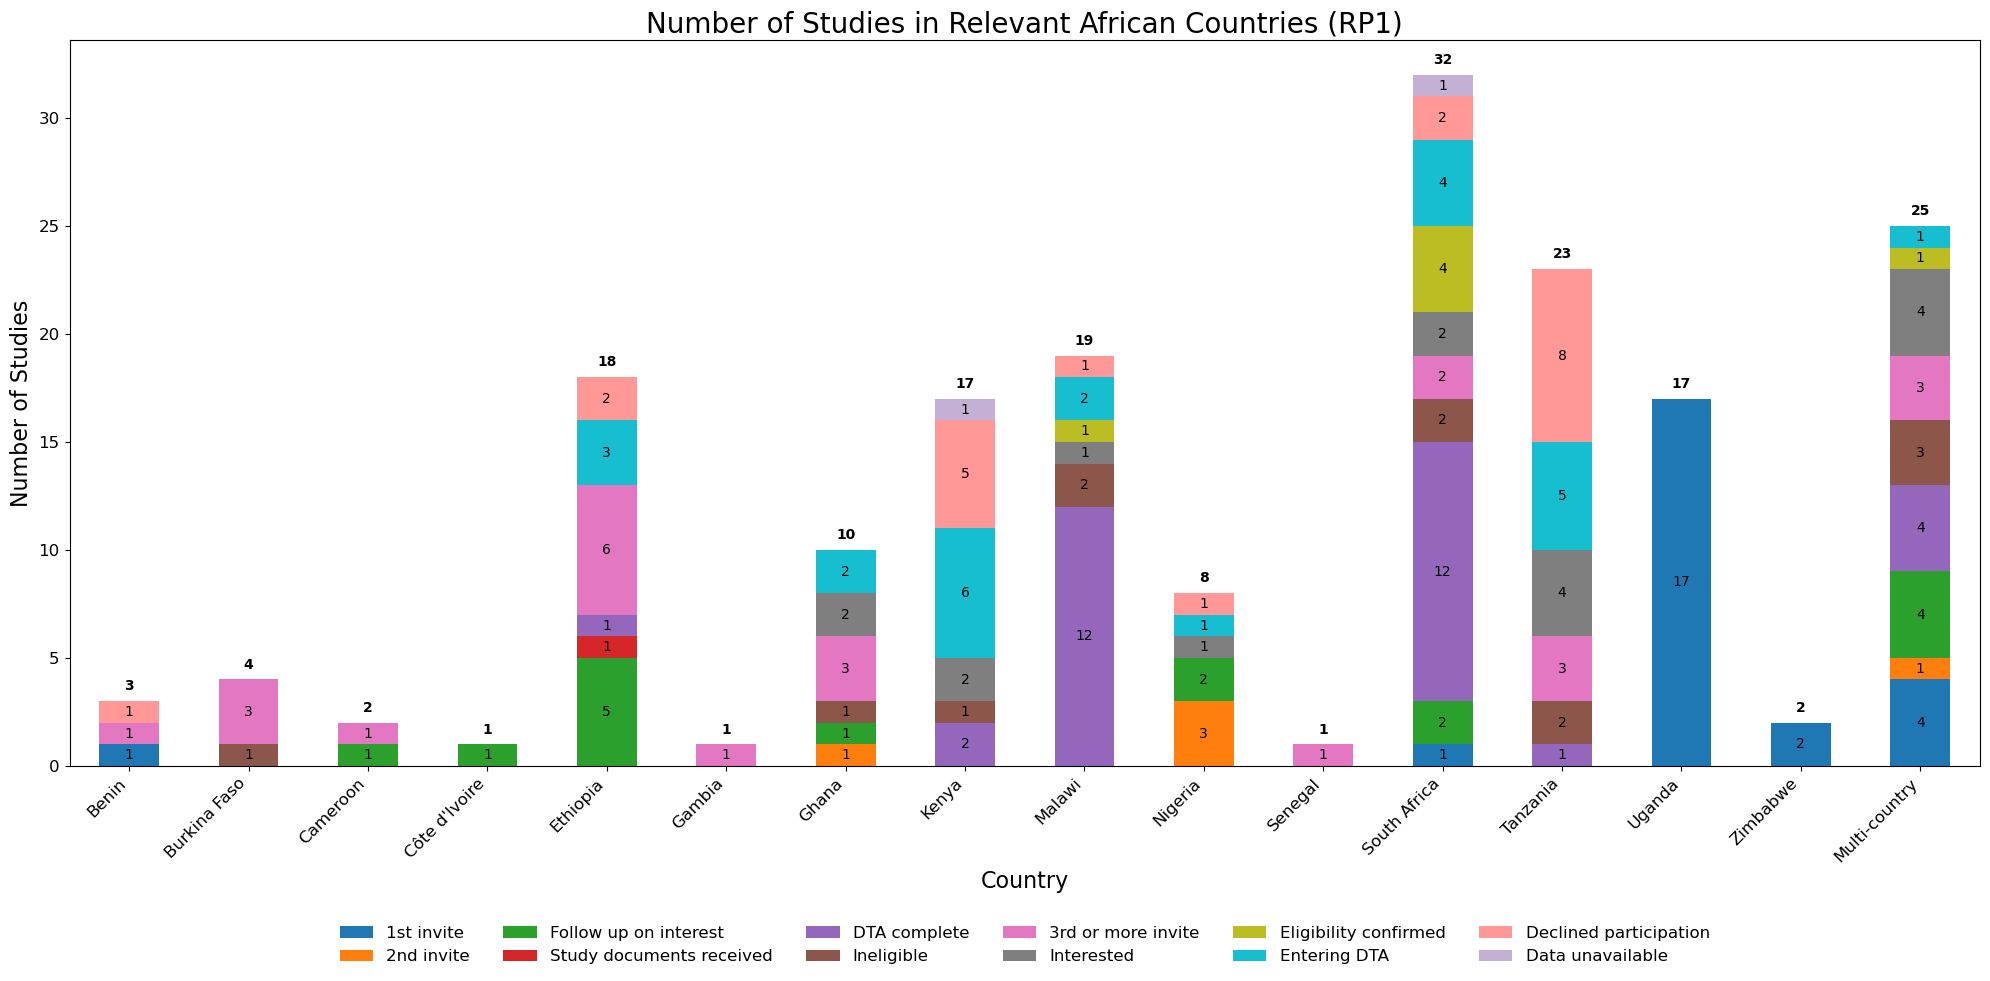

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the Excel file
#file_path = '/mnt/data/HEAT_Tables_0531.xlsx'
df_rp1_countries = pd.read_excel(file_path, sheet_name='RP1_Countries')

# Define the color map and stage order
color_map = {
    '1st invite': '#1f77b4',
    '2nd invite': '#ff7f0e',
    'Follow up on interest': '#2ca02c',
    'Study documents received': '#d62728',
    'DTA complete': '#9467bd',
    'Ineligible': '#8c564b',
    '3rd or more invite': '#e377c2',
    'Interested': '#7f7f7f',
    'Eligibility confirmed': '#bcbd22',
    'Entering DTA': '#17becf',
    'Declined participation': '#ff9896',
    'Data unavailable': '#c5b0d5'
}
stage_order = [
    '1st invite', '2nd invite', 'Follow up on interest', 'Study documents received', 
    'DTA complete', 'Ineligible', '3rd or more invite', 'Interested', 'Eligibility confirmed', 
    'Entering DTA', 'Declined participation', 'Data unavailable'
]

# Set the 'Study site' column as the index
df_rp1_countries.set_index('Study site', inplace=True)

# Move the 'Multi-country' column to the end
multi_country_row = df_rp1_countries.loc['Multi-country']
df_rp1_countries = df_rp1_countries.drop('Multi-country')
df_rp1_countries.loc['Multi-country'] = multi_country_row

# Plot the stacked bar chart
fig, ax = plt.subplots(figsize=(20, 10))  # Increased size of the plot
df_rp1_countries[stage_order].plot(kind='bar', stacked=True, ax=ax, color=[color_map[stage] for stage in stage_order])

# Add the data labels
for container in ax.containers:
    labels = [f'{int(v.get_height())}' if v.get_height() > 0 else '' for v in container]
    ax.bar_label(container, labels=labels, label_type='center')

# Add the total labels on top of each stack
totals = df_rp1_countries[stage_order].sum(axis=1)
for i, total in enumerate(totals):
    ax.text(i, total + 0.5, f'{int(total)}', ha='center', fontsize=10, fontweight='bold')

# Set the title and labels
plt.title('Number of Studies in Relevant African Countries (RP1)', fontsize=20)
plt.xlabel('Country', fontsize=16)
plt.ylabel('Number of Studies', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Place the legend below the plot, stretch it horizontally, and remove the title
ax.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=6, frameon=False, fontsize=12, title_fontsize='13')
plt.tight_layout()

plt.show()


In [12]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Create a DataFrame from the data
df_rp1_countries = pd.read_excel('HEAT_Tables_0531.xlsx', sheet_name='RP1_Countries')

# Calculate the total number of studies for each country
df_rp1_countries['Total Studies'] = df_rp1_countries.drop('Study site', axis=1).sum(axis=1)

# Create a formatted output for each country
df_rp1_countries['Formatted'] = df_rp1_countries['Study site'] + " (n=" + df_rp1_countries['Total Studies'].astype(str) + ")"
formatted_output = df_rp1_countries[['Study site', 'Total Studies']]

# Create a choropleth map
fig = px.choropleth(
    formatted_output,
    locations='Study site',
    locationmode='country names',
    color='Total Studies',
    hover_name='Study site',
    color_continuous_scale=px.colors.sequential.Purples,
    scope='africa',
    title='Number of Studies in Relevant African Countries'
)

fig.update_layout(
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='mercator'
    ),
    title={
        'text': "Number of Studies in Relevant African Countries",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    margin={"r":0,"t":50,"l":0,"b":0},
    height=800
)

# Add country labels
for i, row in formatted_output.iterrows():
    fig.add_trace(go.Scattergeo(
        locationmode='country names',
        locations=[row['Study site']],
        text=[row['Study site']],
        mode='text',
        textposition="middle center",
        showlegend=False,
    ))

fig.show()


C:\Users\cparker\AppData\Local\Temp\ipykernel_50908\3197621327.py:16: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



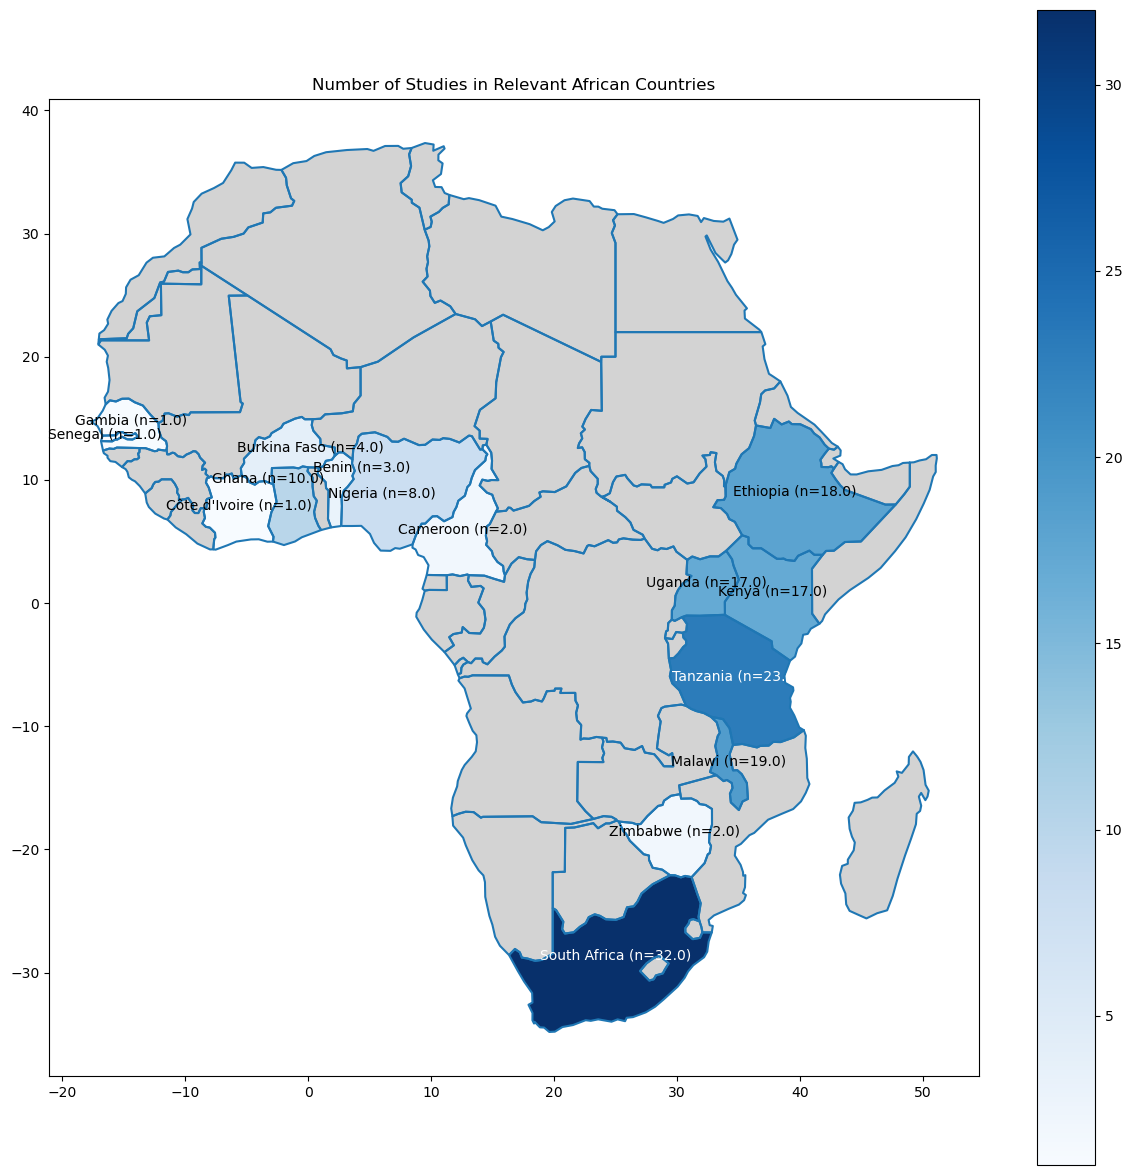

In [13]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the data from the uploaded Excel file
file_path = 'HEAT_Tables_0531.xlsx'
df_rp1_countries = pd.read_excel(file_path, sheet_name='RP1_Countries')

# Calculate the total number of studies for each country
df_rp1_countries['Total Studies'] = df_rp1_countries.drop('Study site', axis=1).sum(axis=1)

# Create a formatted output for each country
df_rp1_countries['Formatted'] = df_rp1_countries['Study site'] + " (n=" + df_rp1_countries['Total Studies'].astype(str) + ")"

# Load the world map data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter the map to show only African countries
africa = world[world['continent'] == 'Africa']

# Merge the country data with the map data
africa = africa.merge(df_rp1_countries, how='left', left_on='name', right_on='Study site')

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
africa.boundary.plot(ax=ax)
africa.plot(column='Total Studies', ax=ax, legend=True, cmap='Blues', missing_kwds={'color': 'lightgrey'})

# Add the labels for each country
for idx, row in africa.iterrows():
    if pd.notna(row['Total Studies']):
        label_color = 'white' if row['Total Studies'] > 20 else 'black'
        # Manually adjust label positions for West Africa
        if row['Study site'] in ['Gambia', 'Senegal', 'Burkina Faso', 'Benin', 'Nigeria', 'Ghana']:
            offset = {
                'Gambia': (1, 1),
                'Senegal': (-2, -1),
                'Burkina Faso': (2, 0),
                'Benin': (2, 1),
                'Nigeria': (-2, -1),
                'Ghana': (-2, 1.9)
            }
            plt.annotate(text=row['Formatted'], xy=(row['geometry'].centroid.x + offset[row['Study site']][0],
                                                    row['geometry'].centroid.y + offset[row['Study site']][1]),
                         horizontalalignment='center', fontsize=10, color=label_color)
        else:
            plt.annotate(text=row['Formatted'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                         horizontalalignment='center', fontsize=10, color=label_color)

plt.title('Number of Studies in Relevant African Countries')
plt.show()


C:\Users\cparker\AppData\Local\Temp\ipykernel_50908\1930409263.py:16: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


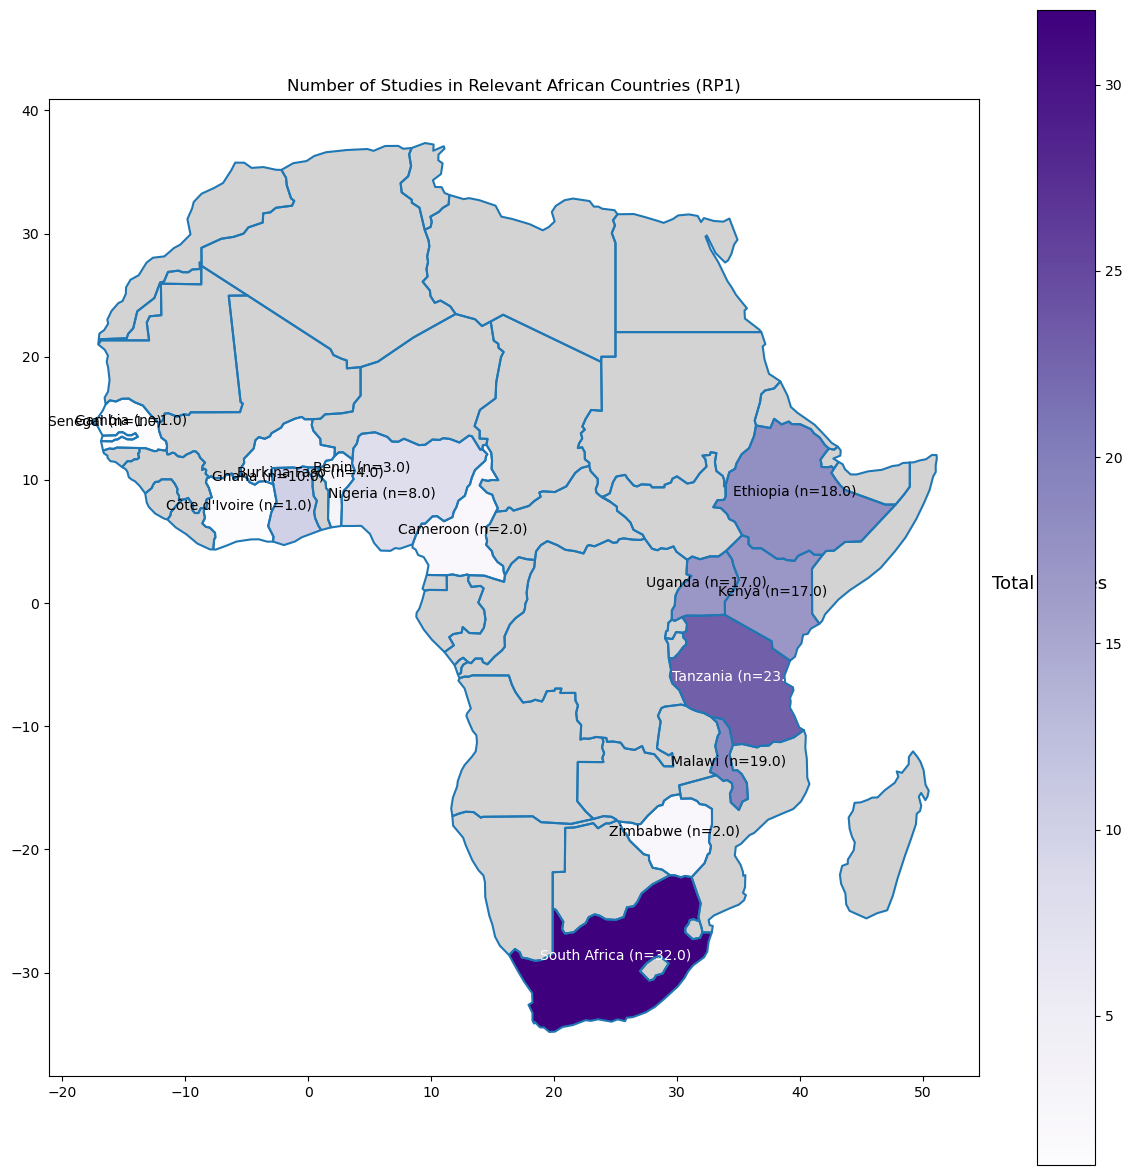

In [14]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the data from the uploaded Excel file

df_rp1_countries = pd.read_excel(file_path, sheet_name='RP1_Countries')

# Calculate the total number of studies for each country
df_rp1_countries['Total Studies'] = df_rp1_countries.drop('Study site', axis=1).sum(axis=1)

# Create a formatted output for each country
df_rp1_countries['Formatted'] = df_rp1_countries['Study site'] + " (n=" + df_rp1_countries['Total Studies'].astype(str) + ")"

# Load the world map data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter the map to show only African countries
africa = world[world['continent'] == 'Africa']

# Merge the country data with the map data
africa = africa.merge(df_rp1_countries, how='left', left_on='name', right_on='Study site')

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
africa.boundary.plot(ax=ax)
africa.plot(column='Total Studies', ax=ax, legend=True, cmap='Purples', missing_kwds={'color': 'lightgrey'})

# Add the labels for each country
for idx, row in africa.iterrows():
    if pd.notna(row['Total Studies']):
        label_color = 'white' if row['Total Studies'] > 20 else 'black'
        # Manually adjust label positions for West Africa
        if row['Study site'] in ['Gambia', 'Senegal', 'Burkina Faso', 'Benin', 'Nigeria', 'Ghana']:
            offset = {
                'Gambia': (1, 1),
                'Senegal': (-2, 0),
                'Burkina Faso': (2, -2),
                'Benin': (2, 1),
                'Nigeria': (-2, -1),
                'Ghana': (-2, 2)
            }
            plt.annotate(text=row['Formatted'], xy=(row['geometry'].centroid.x + offset[row['Study site']][0],
                                                    row['geometry'].centroid.y + offset[row['Study site']][1]),
                         horizontalalignment='center', fontsize=10, color=label_color)
        else:
            plt.annotate(text=row['Formatted'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                         horizontalalignment='center', fontsize=10, color=label_color)

# Remove x and y labels
ax.set_xlabel('')
ax.set_ylabel('')

# Update the title
plt.title('Number of Studies in Relevant African Countries (RP1)')

# Adjust the legend during creation
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, title='Total Studies', title_fontsize='13', fontsize='10')

plt.show()
